# Assigment 5

## Upload your code (.ipynb) on Learn dropbox and submit pdfs of the code and to Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Classification

Download the dataset 
    news20.binary dataset: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#news20.binary
Check Assignment 4 for instructions about loading this dataset.

Question 1
-------------

Solve the l1-regularized logistic regression problem
$$\mbox{minimize}_{x\in\mathbb{R}^d,\beta\in\mathbb{R}} \ \lambda \|x\|_1 + \frac{1}{n} \sum_{i=1}^n \log (1+ \exp(-b_i(a_i^Tx + \beta)))$$
using 

1) Proximal gradient descent

2) Accelerated proximal gradient descent

3) Proximal coordinate descent

4) Accelerated proximal coordinate descent

Tune the model parameter $\lambda$ and any parameters that the algorithms have. You only have to tune $\lambda$ once and use the same $\lambda$ for all algorithms. Use similar techniques to Assignment 4 to tune $\lambda$. Plot the objective function (y-axis) vs running time in sec (x-axis) for all algorithms in the same plot. Make sure that the plots are clean and use appropriate legends. Report your generalization error. This should be measured in the same way as Assignment 4.

For training split the data into training (the first 15996 datapoints), validation (the next 2000 datapoints) and testing (the next 2000 datapoints). Do not use the testing data to influence training in any way. This means that you should compute the generalization error only once when you finish your work with this part of the assignment.

Marks: 15

Question 2
-------------

Pick one algorithm that you want and plot the number of nonzeros in the output of the algorithm against $\lambda$. Explain in a couple of sentences (or less) what do you observe.

Marks: 10

### Question 1 and 2 code and output at very bottom

## Label Propagation

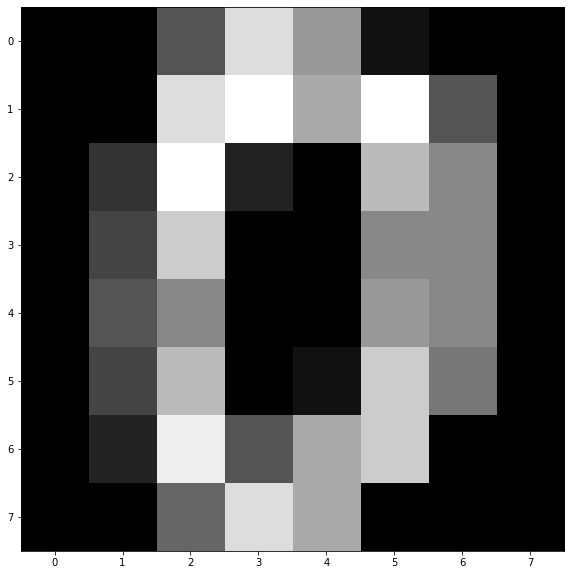

In [297]:
# Load datasets from sklearn
import numpy as np
from numpy.linalg import norm

import sklearn 
from sklearn import datasets
from sklearn.metrics import precision_recall_fscore_support
import sklearn.feature_extraction
from sklearn.model_selection import train_test_split

from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import linalg
from scipy.sparse import hstack

import random
import math
import time
from random import randint

# Load the digits dataset.
# See here for a distription of this dataset: 
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits
digits = datasets.load_digits()

# Briefly, this dataset has 1797 images of digits. The digits are from 0 to 9.
# There are about 180 images per digit.

# digits.data includes the vectorized images of the digits
# digits.target includes the labels of the images
# digits.images includes the images in non-vectorized format

# Example: number 0
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10, 10))
plt.imshow(digits.images[0], cmap='gray')
plt.show()

Let x_i and x_j be two vectorized images.
Compute their pairwise similarity by
$$ 
w_{ij} = \exp(-\gamma \|x_i-x_j\|_2^2),
$$
where $\gamma$ is parameter tha controls the importance of the distance $\|x_i-x_j\|_2^2$. If $\gamma=1/(2\sigma^2)$ then this is called the Gaussian kernel and $\sigma^2$ represents the variance.
You can compute the similarities by using: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html.
Alterantively, you can compute the pairwise similarities manually, by using the above formula.

Sparsify the graph by setting small values to zero. The thresholding tolerance is a parameter that you will have to tune. Generally, there is a consensus that sparse similarity matrices result in better performance. So, you should expect that, but have in mind that this is only an empirical observation.

# Question 3 and 4 Output

In [255]:
# Pairwise weights matrix
# W = sklearn.metrics.pairwise.rbf_kernel(digits.data)

# Remove self-similarity
# W = W - np.eye(len(W))

# Sparsify (tune the tolerance parameter for your problem)
tol = 1e-21
max_iters = 800
# W[abs(W) < tol] = 0.0

def check(cnt, digit, cap):
    return cnt[digit]<cap

def label_propagation(cap):
    # does index of labels that I took out need to match with the index of W
    cnt = [0]*10
    labels = digits.target
    trainingLabels = []
    trainingData = []
    knownLabels = []
    unknownData = []

    for idx in range(len(labels)):
        val = labels[idx]
        if check(cnt, val, cap):
            trainingLabels.append(val)
            trainingData.append(digits.data[idx])
            cnt[val] += 1
        else:
            knownLabels.append(val)
            unknownData.append(digits.data[idx])
    # m data points: 1797 image of a digit, len(W)
    # missing n=1797-100 labels

    w_bar = sklearn.metrics.pairwise.rbf_kernel(unknownData, trainingData) #100*1697 know label x unknown label
    w_bar[abs(w_bar) < tol] = 0.0

    w = sklearn.metrics.pairwise.rbf_kernel(unknownData) #1697*1697 unknown label x unknown label
    w = w - np.eye(len(w))
    w[abs(w) < tol] = 0.0

    # m-n = len(training)
    b = [randint(0, 9) for p in range(0, len(knownLabels))]

    for iters in range(max_iters):
        for j in range(len(knownLabels)):
            numerator = np.sum(w[j]*b) + np.sum(w_bar[j]*trainingLabels)
            denom = np.sum(w[j]) + np.sum(w_bar[j])
            b[j] = numerator/denom

    b = [round(label) for label in b]
    precision, recall, fscore, support = precision_recall_fscore_support(knownLabels, b)
    print("precision:"+str(precision))
    print("recall:"+str(recall))
    print("fscore:"+str(fscore))
    print("support:"+str(support))

print("10 labels per digit:")
label_propagation(10)
print("20 labels per digit:")
label_propagation(20)

10 labels per digit:
precision:[1.         0.94       0.88297872 0.93333333 0.55183946 0.6509434
 0.58823529 0.51655629 0.19230769 0.        ]
recall:[0.99404762 0.27325581 0.99401198 0.7283237  0.96491228 0.80232558
 0.99415205 0.92307692 0.06097561 0.        ]
fscore:[0.99701493 0.42342342 0.93521127 0.81818182 0.70212766 0.71875
 0.73913043 0.66242038 0.09259259 0.        ]
support:[168 172 167 173 171 172 171 169 164 170]
20 labels per digit:
precision:[1.         0.91111111 0.57992565 0.95652174 0.66239316 0.72592593
 0.65714286 0.58167331 0.21153846 0.92857143]
recall:[0.99367089 0.25308642 0.99363057 0.67484663 0.96273292 0.60493827
 1.         0.91823899 0.14285714 0.24375   ]
fscore:[0.9968254  0.39613527 0.73239437 0.79136691 0.78481013 0.65993266
 0.79310345 0.71219512 0.17054264 0.38613861]
support:[158 162 157 163 161 162 161 159 154 160]


#### As you can see, the precesion, recall and fscore is better in the 20 label per digit run especially for label 9. For label 9, we get zero values, but in 20 label per digit run, the values are much better and is similar to the other labels. 

This dataset provides labels for every image of a digit. However, in this assignment we want to check how the label propagation model works. Use all images, i.e., 1797 images of digits, but use only 10 labels per type of digit, e.g., use the first 10 labels for digit 0, the first 10 labels of digit 1 etc. This means that you should use 100 labels in total out of 1797. Do not use the remaining labels for training the model. The remaining labels will be used only to measure accuracy of the model.

Question 3
-------------
Train the label propagation model
$$
\mbox{minimize}_{b\in\mathbb{R}^n} \ \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n w_{ij} (b_i -b_j)^2 + \sum_{i=1}^{m-n}\sum_{j=1}^n \bar{w}_{ij} (\bar{b}_i -b_j)^2
$$
using the coordinate method that was discussed in Lecture 14 for the label propagation problem. Make sure that you understand the derivation of the algorithm before you apply it to train the label propagation model.

The output of the algorithm should be the soft labels $b$ for each image. However, these soft labels are not going to be integers (actual labels). Therefore, we have to round the output labels $b$ to get integer labels for each image. One possible way to round the output is to simply find the integer label (possible options 0 to 9) that a soft label is closest to. Then pick this label as the label of the image.

After you label all images, use the function in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html to measure precision, recall and f1_score. You only have to provide the true and the predicted labels when using this function. Do not change the default parameters.

If you want to learn more about precision, recall and f1_score check Wikipedia: 
precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall
f1_score: https://en.wikipedia.org/wiki/F1_score.

Report precision, recall and f1score of your method.

Marks: 20

Question 4
-------------

Increase the number of labels that are used in the model from 10 per digit to 20 per digit. Re-train and report precision, recall and f1score of your method. Explain in a couple of sentences what do you observe.

Marks: 5

## Local Graph Clustering 

In [19]:
import numpy as np

# Import networkx to load the data
import networkx as nx

# Provide the path of the dataset JohnsHopkins55
path = '/Users/lingxuan925/Documents/CS794/a5/datasets/JohnsHopkins55.graphml'

# This dataset is a Facebook anonymized dataset on a particular day in September 2005 
# for a student social network at John Hopkins university. The graph is unweighted 
# and it represents ``friendship'' ties. This graph has 5157 nodes and 186572 edges. 
# This dataset comes along with 6 features, i.e., second major, high school, gender, dorm, major index and year. 
# We construct ``ground truth'' clusters by using the features for each node.
# In particular, we consider nodes with the same value of a feature to be a cluster, e.g., students of year 2009. 
# For this assignment we will attempt to find the students of year 2009 using local graph clustering.

# Load the data as a graph
G = nx.read_graphml(path).to_undirected()

# Construct the adjacency matrix
A = nx.adjacency_matrix(G).astype(np.float64)

# Indices of nodes (students) of class year 2009
# There should be 910 students of class year 2009.
# We will use these students to measure performance of the model
students_of_year_2009 = []
ct = 0
for node in G.nodes(data=True):
    if node[1]['year'] == 2009:
        students_of_year_2009.append(ct)
    ct += 1
print(len(students_of_year_2009))

910


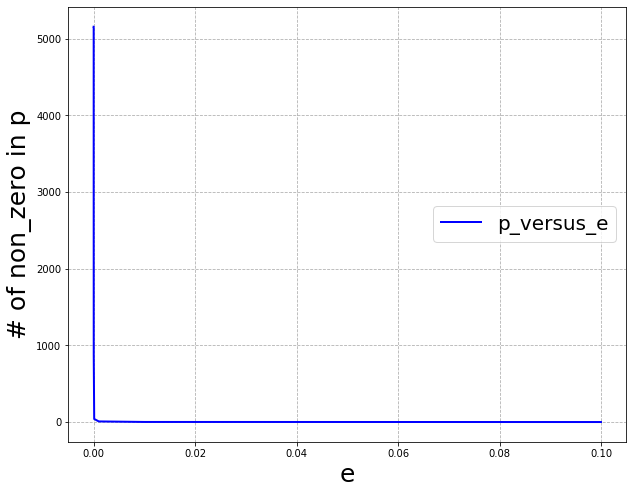

In [228]:
epsilon = 1.0e-1
epsilon_list = [(epsilon**i) for i in range(1,10)]
alpha = 0.1
p_list = []

def satisfy(r, d, epsilon):
    return np.any(r>=(epsilon*d))

def choose(r, d, epsilon):
    u = np.where(r >= (epsilon * d))
#     print(len(u[0]))
    idx = randint(0, len(u[0]))
#     print("idx:"+str(idx))
    node = u[0][idx-1]
    return node
    
def pagerank(A, epsilon, alpha, seed):
    n = A.shape[0]
    p = np.zeros(n)
    d = np.squeeze(np.asarray(np.sum(A, axis=1, dtype=float)))
    r = np.zeros(n)
#     source = randint(0, n)
#     r[source] = 1.0
    r[seed] = 1.0
#     print(source)
    
    while satisfy(r, d, epsilon):
        u = choose(r, d, epsilon)
#         print(u)
        p[u] += alpha*r[u]
        v = A[u].indices
        r[v] = r[v] + 0.5*(1-alpha)*r[u]/d[u]
        r[u] = (1-alpha)*r[u]/2
#         print("vertex "+str(u) + " => residual: "+ str(r[u]))
        
    print(np.count_nonzero(p))
#     p_list.append(np.count_nonzero(p))
    return p
    
seed = 5000
for cnt in range(len(epsilon_list)):
     p_list.append(np.count_nonzero(pagerank(A, epsilon_list[cnt], alpha, seed)))

fig = plt.figure(figsize=(10, 8))
plt.plot(epsilon_list ,p_list, label=("p_versus_e"), linewidth=2.0, color ="blue")
plt.legend(prop={'size': 20},loc="right")
plt.xlabel("e", fontsize=25)
plt.ylabel("# of non_zero in p", fontsize=25)
plt.grid(linestyle='dashed')
plt.show() 

In [247]:
epsilon = 1.0e-6

def conductance(A, p):
    d = np.squeeze(np.asarray(np.sum(A, axis=1, dtype=float)))
#     print(d)
    descIndex = np.argsort(p/d,axis=0)[::-1] # non-increasing
    descVal = np.sort(p/d,axis=0)[::-1]
    n = len(descIndex)
#     print(descVal)
#     result = p/d
#     print(result[5000])
#     print(result[4643])
    cluster = []
#     for idx in range(len(descIndex)):
#         if descVal[descIndex[idx]] != 0:
#             print("idx: "+str(descIndex[idx]))
#             print("value: "+str(descVal[descIndex[idx]]))
#             cluster.append(descIndex[idx])
    universe = [i for i in range(5157)]
#     cluster_bar = np.setdiff1d(universe, cluster)
    i = 0
    minCond = 1.0
    minIdx = i
    while i<n and p[descIndex[i]] != 0:
        node = descIndex[i]
#         print(node)
        cluster.append(node)
        cluster_bar = np.setdiff1d(universe, cluster)
        edgesLeaving = np.sum(A[cluster].T[cluster_bar])
    #     print(len(cluster))
    #     print(len(cluster_bar))
    #     print(d[cluster])
    #     print(np.sum(d[cluster]))
        cond = edgesLeaving/np.sum(d[cluster])
#         print("i => "+str(i)+": "+str(cond))
        if cond<minCond:
            minCond=cond
            minIdx = i
        i+=1
#     print(minIdx)
    return descIndex[:minIdx]
    
p = pagerank(A, epsilon, alpha, seed)
# print(np.count_nonzero(p))
output_cluster = conductance(A, p)
# print(output_cluster)
print(len(output_cluster))

942


# Question 6 Output

In [250]:
def measure(students_of_year_2009, output_cluster):
    true = set(students_of_year_2009)
#     print(true)
    prediction = set(output_cluster)
#     print(prediction)
    tp = len(true.intersection(prediction))
    fp = len(prediction) - tp
#     print(len(true))
#     print(len(prediction))
    return tp, fp

tp, fp = measure(students_of_year_2009, output_cluster)
print("true positive: "+str(tp))
print("false positive: "+str(fp))

true positive: 855
false positive: 87


# Question 7 Output

In [252]:
seed = 146

p = pagerank(A, epsilon, alpha, seed)
# print(np.count_nonzero(p))
output_cluster = conductance(A, p)
# print(output_cluster)
print(len(output_cluster))

tp, fp = measure(students_of_year_2009, output_cluster)
print("true positive: "+str(tp))
print("false positive: "+str(fp))

3647
true positive: 900
false positive: 2747


#### Results are very different between seed 5000 and seed 146 with respect to false positives. Seed 146 has a lot more false positives (2747 versus 87 from seed 5000). The student corresponding to seed 146 may belong to the class of 2009 so he associated with students of that year, but this student may also have a lot of friends in other classes that are from different years other than 2009 (upper or lower year students)

The target cluster is the students of year 2009 in the list: students_of_year_2009.

For this problem you will have to use the coordinate algorithm that was introduced in Lecture 14.

The coordinate algorithm returns a vector $p$. To get an actual cluster from vector $p$ you will have to round the output of the coordinate algorithm using the rounding technique that was discussed in Lecture 14. 

To measure accuracy of the rounded output you can use number of true positives and the number of false positives of the predicted cluster. True positives are the predicted nodes that are also part of class year 2009. False positive are the number of predicted nodes that are not part of the class year 2009.

Question 5
-------------

1) Report the number of nonzero nodes in the output of the coordinate algorithm (vector $p$) as the tolerance parameter $\epsilon$ goes to zero. In particular, plot the number of nonzeros in the output $p$ against $\epsilon$.
The number of nonzeros should increase as $\epsilon$ goes to zero.

Marks: 10

Question 6
-------------

2) Run the coordinate algorithm using as seed node the node with index 5000. Round the output to get an actual cluster back. Measure true positives and false positives of the predicted cluster. Report these two numbers.

Marks: 10

Question 7
-------------

3) Run the coordinate algorithm using as seed node the node with index 146. Round the output to get an actual cluster back. Measure true positives and false positive of the predicted cluster. Report these two numbers. How do they compare to the results in 2) ? Are they different? If yes, why do you think this might have happened? Explain intuitively in a couple of sentences why you think this might happen.

Marks: 5

## Reccomender System

Download the data matrix $A$ from the webiste https://grouplens.org. Navigate to the dataset tab https://grouplens.org/datasets/movielens/ and download the dataset MovieLens 100K. Read the description of the dataset carefully. 
This dataset includes 5 data matrices $A$. We only need to use one of these in this assignment. In particular, use the dataset u1.base. Use the corresponding testing data u1.test to measure the accuracy of your model. For this question only it's ok if you use the testing data to tune parameters. Ignore the timestap feature in the dataset. We do not need this for this problem.

Question 8
------------

Solve the penalized problem
$$
\mbox{minimize} \ \lambda \|X\|_* + \sum_{ij \ | \ A_{ij} \ is \ known} (X_{ij} - A_{ij})^2,
$$
where $\|X\|_*$ is the nuclear norm, using proximal gradient descent. This algorithm requires thresholding the singular values of $X$ at each iteration.
You can use https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html (sparse matrices) or https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html (dense matrices).

To check your solution against u1.test, report your score as follows. Let $X$ be the output of the proximal gradient method, let $A'$ and $\Omega'$ be the data matrix and the non-zero entry list for the test data. Then the score is 
$$
\frac{1}{|\Omega'|} \sum_{(i,j)\in\Omega'} | X_{ij} - A_{ij}'|.
$$
In other words, the average absolute deviation of the computed ratings from the predicted ratings. Report your score.

Marks: 15

Question 9
------------

Now consider the factorized problem
$$
\mbox{minimize}_{L,R} \ \frac{\lambda}{2} \left(\|L\|_F^2 + \|R\|_F^2\right) + \|W\circ (LR^T-A)\|_F^2
$$
See Lecture 15 about details for this problem. Solve this problem and obtain the matrix $X=LR^T$. Use $X$ as the predicted rating and report your score. For calculating derivatives of matrix functions you can have a look here: https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf. 

Marks: 10

In [415]:
import re 

In [416]:
users = 943
movies = 1682
A = np.zeros([users, movies])
with open('./datasets/ml-100k/u1.base') as file:
    for line in file:
        line = re.findall(r"[\w']+", line) # user id | item id | rating | timestamp
        user = int(line[0])
        item = int(line[1])
        rating = int(line[2])
        A[user-1][item-1] = rating # user and item start from index 1 in dataset 

In [417]:
test_user = 462
test_movies = 1591
test = np.zeros([test_user, test_movies])
with open('./datasets/ml-100k/u1.test') as file:
    for line in file:
        line = re.findall(r"[\w']+", line) # user id | item id | rating | timestamp
        user = int(line[0])
        item = int(line[1])
        rating = int(line[2])
        test[user-1][item-1] = rating 

In [418]:
def obj_func_penalized(X, A):
    nonZeroIdx = np.nonzero(A)
    return np.sum(np.square(X[nonZeroIdx]-A[nonZeroIdx]))

def gradient(X, A):
    nonZeroIdx = np.where(A==0)
    derivative = 2*(X-A)
#     print(result)
    derivative[nonZeroIdx] = 0
    return derivative

In [419]:
def proximal(X, alpha, lambda_):
    u, s, vh = linalg.svd(X)
#     print(u)
    proximal_operator = np.where(s>=alpha*lambda_, s-alpha*lambda_, 0)
    zbar = np.zeros([len(s), vh.shape[0]])
    np.fill_diagonal(zbar, proximal_operator)
    Z = (u.dot(zbar)).dot(vh)
    return Z

def nuclearNorm(X, lambda_):
    u, s, vh = np.linalg.svd(X, full_matrices=True)
    return lambda_*np.sum(np.array(s))

In [430]:
def armijo(x_k, A, lambda_):
    theta = 0.5
    alpha = 1.0
    
    term2 = obj_func_penalized(x_k, A)
    nuclear = nuclearNorm(x_k, lambda_)
    obj = nuclear + term2
    obj_k = obj
    
    obj_grad = gradient(x_k, A)
    
    i = 1
    while True:
        xkplus1 = x_k - alpha * obj_grad #step size
        Z = proximal(xkplus1, alpha, lambda_)
        nuclear_Z = nuclearNorm(Z, lambda_)
        term2_Z = obj_func_penalized(Z, A) 
        obj_Z = nuclear_Z + term2_Z
        Z_k = nuclear_Z + term2 + np.sum((obj_grad)*(Z - x_k))
        
        if obj_Z <= obj - theta*(obj_k - Z_k): break
        
        alpha /= 2
        i += 1
    return Z, obj_Z, alpha

def proximal_gradient_descent(X, A, lambda_, epsilon, max_iters):
    i = 1
    while i < max_iters:
        Z, R, alpha = armijo(X, A, lambda_)
#         print(Z)
        grad = (1/alpha)*(X-Z)
        if norm(grad, 2) <= epsilon: break
            
#         print(R)
       
        X = Z
        i += 1
    return X

In [431]:
def deviation(test, prediction):
    nonZeroIdx = np.nonzero(test)
    return np.sum(np.abs(prediction[nonZeroIdx]-test[nonZeroIdx]))/np.count_nonzero(test)

In [432]:
lambda_= 2
max_iters = 120
epsilon = 1.0e-5
weights = np.random.randint(1, 6, size=([A.shape[0],A.shape[1]]))

predict = proximal_gradient_descent(weights, A, lambda_, epsilon, max_iters)
# print(predict)
        
print("score: "+str(deviation(test, predict)))

score: 0.7860719382696947


## Question 9 output

In [443]:
def gradientL(W, A, L, R, lambda_):
    return lambda_*L + 2*(W*(L.dot(R.T)-A)).dot(R)

def gradientR(W, A, L, R, lambda_):
    return lambda_*R + 2*((W*(L.dot(R.T)-A)).T).dot(L)

In [444]:
def alternating_minimization(X, A, lambda_, alpha, max_iters):
    W = np.zeros(A.shape)
    nonZeroIdx = np.nonzero(A)
    W[nonZeroIdx] = 1
    L,RT = np.linalg.qr(X)
    R = RT.T
    
    i = 0
    while i < max_iters:
        R = R-alpha*gradientR(W, A, L, R, lambda_)
        L = L-alpha*gradientL(W, A, L, R, lambda_)
        i += 1
    return R, L

In [445]:
max_iters = 400
alpha = 0.0001
R, L = alternating_minimization(np.zeros(A.shape), A, lambda_, alpha, max_iters)
prediction = L.dot(R.T)
print("score_alternating_minimization: "+str(deviation(test, prediction)))

score_alternating_minimization: 0.7514488648297533


## Nonnegative Matrix Factorization: facial feature extraction

Dataset consists of 400 faces


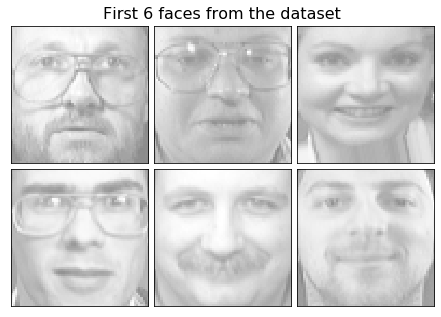

In [450]:
# This piece of code is for loading data and visualizing 
# the first 6 images in the dataset.

# Useful packages for loading the data and plotting
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

n_row, n_col = 2, 3
image_shape = (64, 64)
rng = RandomState(0)

# Useful function for plotting
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)

# Store the vectorized images. Each image has dimensions 64 x 64.
faces = dataset.data

n_samples = faces.shape[0]
print("Dataset consists of %d faces" % n_samples)
    
plot_gallery("First 6 faces from the dataset", faces[:6])    

In [451]:
def obj_func(W, H, X):
    result = W.dot(H)-X
    return np.trace(result.dot(result.T))/2

In [452]:
def gradientW(W, H, X):
    result = W.dot(H)-X
    return result.dot(H.T)

def gradientH(W, H, X):
    result = W.dot(H)-X
    return W.T.dot(result)

In [453]:
def WHbar(WH, gradientWH, sigma):
    maxWH = np.where(WH>sigma, WH, sigma)
    WH = np.where(gradientWH>=0, WH, maxWH)
    return WH

In [462]:
def extract(X, sigma, delta, max_iters):
    H = np.random.random([6, X.shape[1]])
    deltaH = delta*np.ones(H.shape)
    
    W = np.random.random([X.shape[0], 6])
    deltaW = delta*np.ones(W.shape)
    
    i = 0
    while i < max_iters:
        gradH = gradientH(W, H, X)
        Hbar = WHbar(H, sigma, gradH)
        
        gradW = gradientW(W, H, X)
        Wbar = WHbar(W, sigma, gradW)
        
        denomH = (W.T.dot(W)).dot(Hbar)+deltaH #lecture 16 page 25
        H_k = H - np.divide(Hbar, denomH)*gradH
        
        gradient_W_Hk = gradientW(W, H_k, X)
        denomW = Wbar.dot(H.dot(H.T))+deltaW
        W_k = W-np.divide(Wbar, denomW)*gradient_W_Hk
        
        H = H_k
        W = W_k
#         print(obj_func(W, H, X))
        i += 1
        
    return H, W

## Question 10 , 11, and 12 output

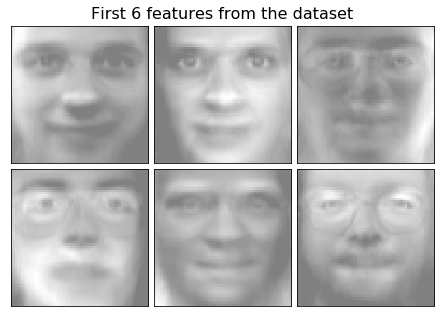

In [469]:
sigma = 0.6
delta = 0.6
max_iters = 800
H_extract, W_extract = extract(faces.T, sigma, delta, max_iters)
plot_gallery("First 6 features from the dataset", W_extract.T[:6]) 

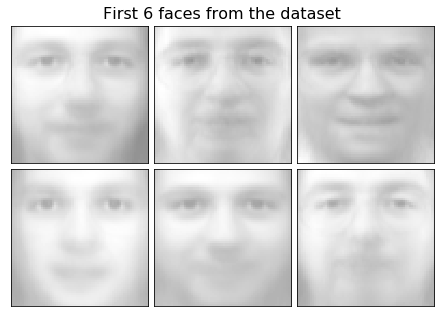

In [470]:
result = W_extract.dot(H_extract)
plot_gallery("First 6 faces from the dataset", result.T[:6]) 

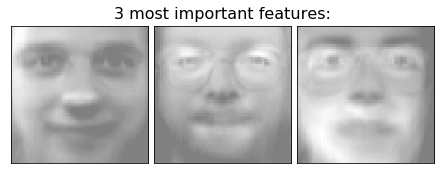

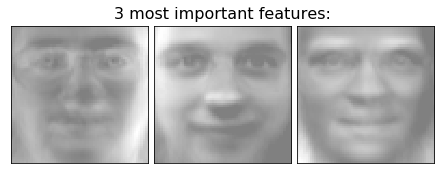

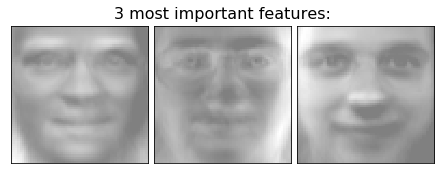

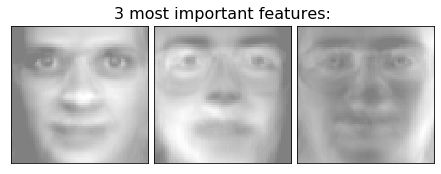

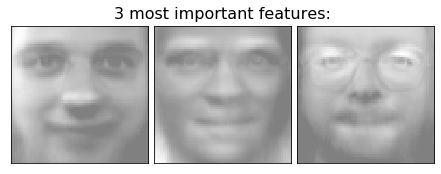

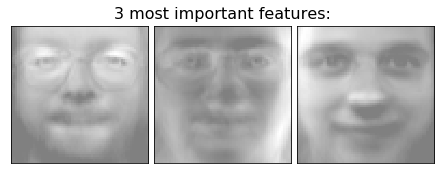

In [471]:
for i in range(6):
    six_images = H_extract[:,i]
    sort = np.argsort(six_images, axis=0)[::-1]
    plot_gallery("3 most important features:", W_extract.T[sort[:3]]) 

Question 10
--------------

Use the data in "faces" from the above code for the nonnegative matrix factorization problem 
\begin{align*}
\mbox{minimize}_{W,H} &  \ \| WH-Χ\|_F^2\\
\mbox{subj. to} & \ W_{ij}\ge 0 \ \forall i,j \\
                &  \ H_{ij}\ge 0 \ \forall i,j
\end{align*}
where $W\in\mathbb{R}^{m\times r}$ and $H\in\mathbb{R}^{r\times n}$.
Set parameter $r=6$ in the nonnegative factorization problem. Extract the features matrix $W$ by solving the non-negative matrix factorization problem. Report the 6 features of the faces dataset, i.e., the 6 columns of matrix $W$. You can report the features by visualizing them in a similar way to the above example.

Marks: 15

Question 11
--------------

Visualize the approximation of the first 6 images using the feature matrix $W$ and the importance matrix $H$. Note that each face can be approaximated by a linear combination of features (columns) from matrix $W$. The positive coefficients of this linear combination are given by matrix $H$.

Marks: 5

Question 12
--------------

Use matrix $H$ to find the 3 most important features of the first 6 faces. To find the 3 most important features for an image pick the columns of $W$ with the largest coefficients in matrix $H$.

Marks: 5

# Question 1 Code

In [472]:
import sys
import matplotlib.pyplot as plt
# Numpy is useful for handling arrays and matrices.
import numpy as np
from numpy.linalg import norm
import time
from scipy.sparse import csr_matrix
from scipy import sparse
import sklearn.feature_extraction
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import random

# add here your path to the folder libsvm-3.24/python
path = "/Users/lingxuan925/Documents/CS794/a5/libsvm-3.24/python/"
sys.path.append(path)
# Load the LIBSVM module.
from svmutil import *
# Add here your path to the folder libsvm-3.24
path = "/Users/lingxuan925/Documents/CS794/a5/libsvm-3.24/"

In [473]:
path = "/Users/lingxuan925/Documents/CS794/a4/datasets/news20.binary"
trainLabel, trainData = svm_read_problem(path)

vector = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
trainData = vector.fit_transform(trainData)
trainLabel = np.array([trainLabel]).T

# add a column of 1
n = trainData.shape[0]
ones = np.ones((n,1))
trainData = hstack([ones, trainData]).tocsr()
features = trainData.shape[1]

t_D, v_D, t_L, v_L = train_test_split(trainData, trainLabel, test_size=0.2)
v_D, testData, v_L, testLabel = train_test_split(v_D, v_L, test_size=0.5)
weights = np.random.normal(0.0,1.0,[trainData.shape[1],1])/trainData.shape[1]

def validation(weights, vlabel, matrix):
    p = 1/(np.exp(-matrix*weights)+1)
    p = np.where(p > 0.5, 1,-1)
    e = np.sum(abs(p - vlabel))
    e = e/len(p)
    e = e/2
    return p, e

In [474]:
def obj_func_term2(x, b, a):
    return (1/b.shape[0])*np.sum(np.log(1+np.exp(-b*a.dot(x))))

def obj_func_term1(x, lambda_):
    return lambda_*norm(x, 1)

def gradient(x, b, a):
    grad = ((1/b.shape[0])*np.sum(a.multiply(-b/(1+np.exp(b*a.dot(x)))),axis = 0)).T
    return np.array(grad)

def soft_threshod(step, mu):
#     threshold = np.where(step>=(alpha*lambda_), step-(alpha*lambda_), step)
#     threshold = np.where(np.absolute(step)<=(alpha*lambda_), 0, threshold)
#     threshold = np.where(step<=-(alpha*lambda_), step+(alpha*lambda_), threshold)
#     return threshold
    return np.multiply(np.sign(step), np.maximum(np.abs(step)- mu,0))  

def armijo(x_k, b, a, lambda_):
    theta = 0.5
    alpha = 1.0
    
    term2 = obj_func_term2(x_k, b, a)
    term1 = obj_func_term1(x_k, lambda_)
    obj = term1 + term2
    obj_k = obj
    
    obj_grad = gradient(x_k, b, a)
    
    i = 1
    while True:
        xkplus1 = x_k-alpha*obj_grad #step size
        Z = soft_threshod(xkplus1, alpha*lambda_)
        term1_Z = obj_func_term1(Z, lambda_)
        term2_Z = obj_func_term2(Z, b, a) 
        obj_Z = term1_Z+term2_Z
        Z_k = term1_Z+term2+(obj_grad.T).dot(Z-x_k)
        
        if obj_Z <= obj - theta*(obj_k - Z_k): break
        
        alpha /= 2
        i += 1
    return Z, obj_Z, alpha

def proximal_gradient_descent(X, b, A, lambda_, epsilon, max_iters):
    i = 1
    obj_func_val = []
    runTime = []
    startTime = time.time()
    
    while i < max_iters:
        Z, R, alpha = armijo(X, b, A, lambda_)
#         print(Z)
        grad = (1/alpha)*(X-Z)
        obj_func_val.append(R)
        runTime.append(time.time()-startTime)
        if norm(grad, 2) <= epsilon: break
            
#         print(R)
       
        X = Z
        i += 1
    return X, obj_func_val, runTime

In [497]:
lambda_=0.0001
iterations = 1500
epsilon = 1.0e-3
X, obj_func_val_proximal, runTime_proximal = proximal_gradient_descent(weights, t_L, t_D, lambda_, epsilon, iterations)
prediction, error = validation(X, v_L, v_D)
print(error)

0.197


In [498]:
prediction, error = validation(X, testLabel, testData)
print(error)

0.188


In [499]:
def accelerated_proximal_gradient(X,  b, A, lambda_, epsilon, max_iters):
    i = 1
    obj_func_val = []
    runTime = []
    startTime = time.time()
    Y = X
    t = 1
    t_prev = t 
    while i < max_iters:
        Z, R, alpha = armijo(Y, b, A, lambda_)
        gradY = (1/alpha)*(Y - Z)
        
        t = (1/2)*(1+(1+4*(t**2))**(0.5))
        Y = Z+((t_prev-1)/t)*(Z-X)
        t_prev=t
        X=Z
        
        obj_func_val.append(R)
        runTime.append(time.time()-startTime)
        
        if norm(gradY, 2) <= epsilon: break
        i += 1
    return X, obj_func_val, runTime

In [500]:
weights = np.random.normal(0.0,1.0,[trainData.shape[1],1])/trainData.shape[1]
X, obj_func_val_accelerated, runTime_accelerated = accelerated_proximal_gradient(weights, t_L, t_D, lambda_, epsilon, iterations)
prediction, error = validation(X, v_L, v_D)
print(error)
prediction, error = validation(X, testLabel, testData)
print(error)

0.0995
0.098


In [523]:
def coordinate_proximal_gradient(X, b, A, features):
    return (1/b.shape[0]*np.sum(A[:,features].multiply((-b/(np.exp(b*A.dot(X))+1))), axis=0)).T

In [524]:
def coordinate_proximal_armijo(x_k, b, A, lambda_, features):
    theta = 0.5
    alpha = 700
    i = 1
    
    term1 = obj_func_term1(x_k, lambda_)
    term2 = obj_func_term2(x_k, b, A)
    obj = term1 + term2
    
    obj_k = lambda_*norm(x_k[features], 1)+term2
    
    gradient = coordinate_proximal_gradient(x_k, b, A, features)

    x_next = x_k
    x_k_proximal = x_k[features]
    
    while True:
        step = x_k_proximal-alpha*gradient
        Z = soft_threshod(step, alpha*lambda_)
        
        x_next[features] = Z
        term1_Z = obj_func_term1(x_next, lambda_)
        term2_Z = obj_func_term2(x_next, b, A) 
        obj_Z = term1_Z+term2_Z

        Z_k = lambda_*norm(Z, 1)+obj+(gradient.T).dot(Z-x_k_proximal)
        
        if obj_Z<=obj-theta*(obj_k-Z_k): break
            
        alpha /= 2
        i += 1
    return x_next, obj_Z, alpha

In [537]:
def coordinate_proximal_descent(X, b, A, lambda_, epsilon, max_iters):
    block = 1
    blocks = math.ceil(len(X)/block)
    iters = 1
    
    
    runTime = [0]
#     runTime.append(0)
    startTime = time.time()
    
    term1 = obj_func_term1(X, lambda_)
    term2 = obj_func_term2(X, b, A)
    obj = term1+term2
    
    obj_func_val = [obj]
    X_step = X
    while iters<max_iters:
        for i in range(blocks):
            if(i<blocks-1):
                idx = np.array(range(i*block, (i+1)*block))
            else:
                idx = np.array(range(i*block, len(X)))
                
            X_step, R, alpha = coordinate_proximal_armijo(X_step, b, A, lambda_, idx)
            
            runTime.append(time.time()-startTime)
            obj_func_val.append(R)
            if i>max_iters: break

        gradX = (1/alpha)*(X-X_step)
        X = X_step
        print(iters)
        
        if norm(gradX, 2)<=epsilon: break
            
        iters += 1
    return X, obj_func_val, runTime

In [539]:
weights = np.random.normal(0.0, 1.0, [trainData.shape[1], 1])/trainData.shape[1]
iterations = 1200
X, obj_func_val_coordinate, runTime_coordinate = coordinate_proximal_descent(weights, t_L, t_D, lambda_, epsilon, iterations)
prediction, error = validation(X, v_L, v_D)
print("validation: "+str(error))
prediction, error = validation(X, testLabel, testData)
print("test: "+str(error))

1
validation: 0.2955
test: 0.3015


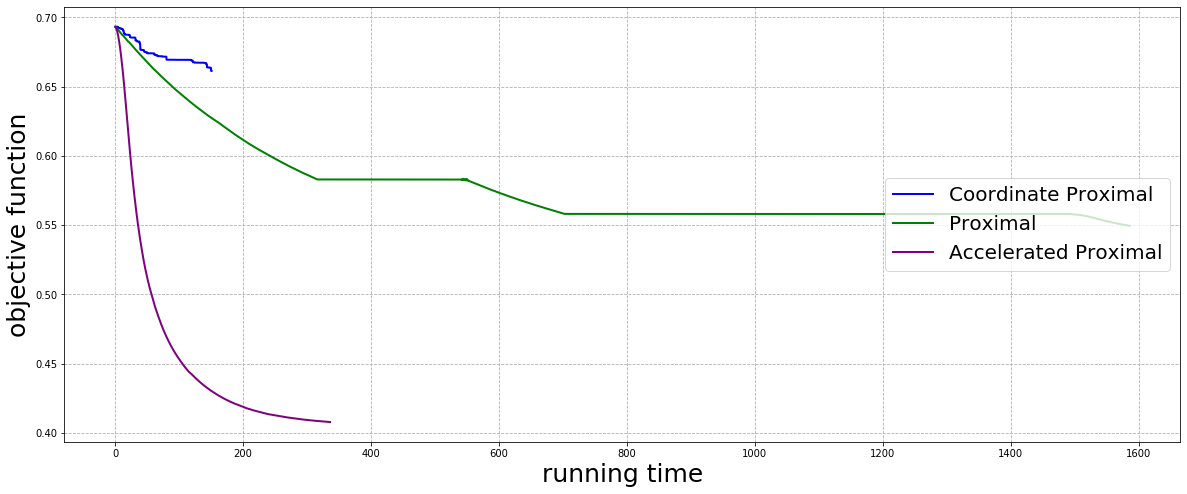

In [540]:
fig = plt.figure(figsize=(20, 8))
plt.plot(runTime_coordinate, obj_func_val_coordinate, label=("Coordinate Proximal"), linewidth=2.0, color ="blue")
plt.plot(runTime_proximal, obj_func_val_proximal, label=("Proximal"), linewidth=2.0, color ="green")
plt.plot(runTime_accelerated, obj_func_val_accelerated, label=("Accelerated Proximal"), linewidth=2.0, color ="purple")
plt.legend(prop={'size': 20},loc="right")
plt.xlabel("running time", fontsize=25)
plt.ylabel("objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 2

In [542]:
lambda_list = [(lambda_*i*5) for i in range(1,10)]
count_nonzero_list = []
weights = np.random.normal(0.0, 1.0, [trainData.shape[1], 1])/trainData.shape[1]

for i in range(len(lambda_list)):
    X, obj_func_q2, runTime_q2 = accelerated_proximal_gradient(weights, t_L, t_D, lambda_list[i], epsilon, max_iters)
    count_nonzero_list.append(np.count_nonzero(X))          

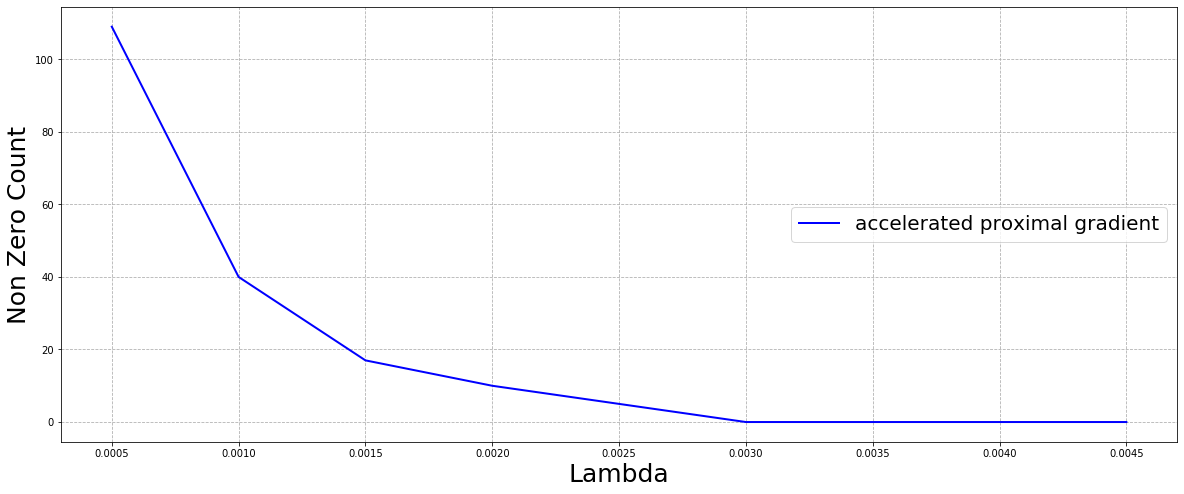

In [543]:
fig = plt.figure(figsize=(20, 8))
plt.plot(lambda_list, count_nonzero_list, label=("accelerated proximal gradient"), linewidth=2.0, color ="blue")
plt.legend(prop={'size': 20}, loc="right")
plt.xlabel("Lambda", fontsize=25)
plt.ylabel("Non Zero Count", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()  

### As lambda gets bigger, the count of non zeros in the weight matrix decreases to zero (the matrix has more zero values).